### Installing Dependencies

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, when, col
import matplotlib.pyplot as plt

### Installing Dataset

In [2]:
spark = SparkSession.builder.appName("Ecommerce Analysis").getOrCreate()
ecommerce_df = spark.read.csv("ecommerce_transactions.csv", header=True, inferSchema=True)
ecommerce_df.show()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/01 23:47:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------+---------------+---+---------+----------------+---------------+----------------+----------------+
|Transaction_ID|      User_Name|Age|  Country|Product_Category|Purchase_Amount|  Payment_Method|Transaction_Date|
+--------------+---------------+---+---------+----------------+---------------+----------------+----------------+
|             1|       Ava Hall| 63|   Mexico|        Clothing|         780.69|      Debit Card|      2023-04-14|
|             2|    Sophia Hall| 59|    India|          Beauty|         738.56|          PayPal|      2023-07-30|
|             3|Elijah Thompson| 26|   France|           Books|         178.34|     Credit Card|      2023-09-17|
|             4|   Elijah White| 43|   Mexico|          Sports|         401.09|             UPI|      2023-06-21|
|             5|     Ava Harris| 48|  Germany|          Beauty|         594.83|     Net Banking|      2024-10-29|
|             6|  Elijah Harris| 51|    India|            Toys|          966.5|Cash on D

### Exploring Dataset

In [3]:
row_count = ecommerce_df.count()
col_count = len(ecommerce_df.columns)

print(f"Number of rows: {row_count}, Number of columns: {col_count}")

Number of rows: 50000, Number of columns: 8


In [4]:
ecommerce_df.printSchema()

root
 |-- Transaction_ID: integer (nullable = true)
 |-- User_Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Product_Category: string (nullable = true)
 |-- Purchase_Amount: double (nullable = true)
 |-- Payment_Method: string (nullable = true)
 |-- Transaction_Date: date (nullable = true)



In [5]:
ecommerce_df.describe(["Age", "Purchase_Amount"]).show()

+-------+----------------+------------------+
|summary|             Age|   Purchase_Amount|
+-------+----------------+------------------+
|  count|           50000|             50000|
|   mean|        43.96868|503.15979300000197|
| stddev|15.2605778646267| 286.5635576146599|
|    min|              18|              5.04|
|    max|              70|            999.98|
+-------+----------------+------------------+



In [6]:
print("Missing values per column:")
ecommerce_df.select([(ecommerce_df[col].isNull()).alias(col) for col in ecommerce_df.columns]).show()

Missing values per column:
+--------------+---------+-----+-------+----------------+---------------+--------------+----------------+
|Transaction_ID|User_Name|  Age|Country|Product_Category|Purchase_Amount|Payment_Method|Transaction_Date|
+--------------+---------+-----+-------+----------------+---------------+--------------+----------------+
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|    false|false|  false|           false|          false|         false|           false|
|         false|   

In [7]:
duplicates = ecommerce_df.count() - ecommerce_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### Cleanings the Data

In [8]:

# numeric columns
avg_purchase = ecommerce_df.select(mean(col("Purchase_Amount"))).collect()[0][0]
ecommerce_df = ecommerce_df.withColumn("Purchase_Amount", when(col("Purchase_Amount").isNull(), avg_purchase).otherwise(col("Purchase_Amount")))

# categorical columns
mode_country = ecommerce_df.groupBy("Country").count().orderBy("count", ascending=False).first()["Country"]
ecommerce_df = ecommerce_df.fillna({"Country": mode_country})

In [9]:
ecommerce_df = ecommerce_df.dropDuplicates()

### Visualizing the Data

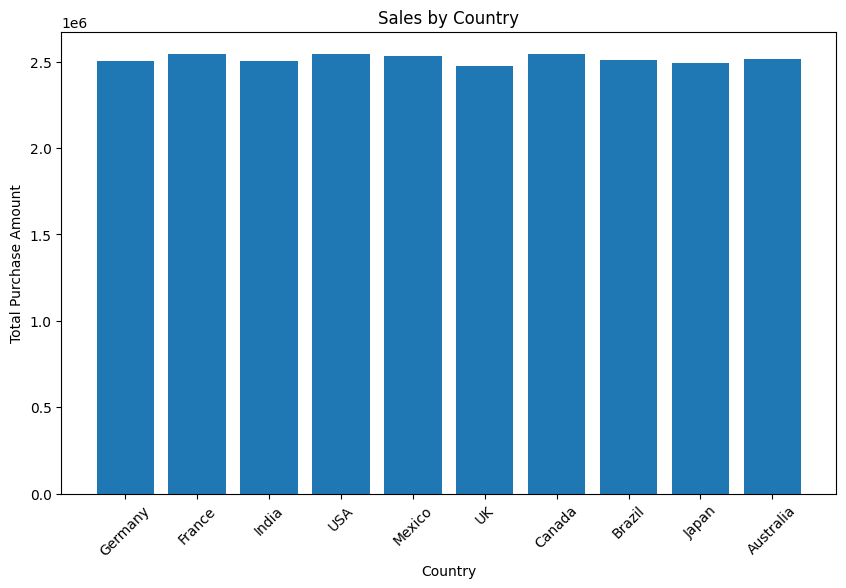

In [10]:
country_sales = ecommerce_df.groupBy("Country").sum("Purchase_Amount").toPandas()
plt.figure(figsize=(10, 6))
plt.bar(country_sales["Country"], country_sales["sum(Purchase_Amount)"])
plt.title("Sales by Country")
plt.xlabel("Country")
plt.ylabel("Total Purchase Amount")
plt.xticks(rotation=45)
plt.show()

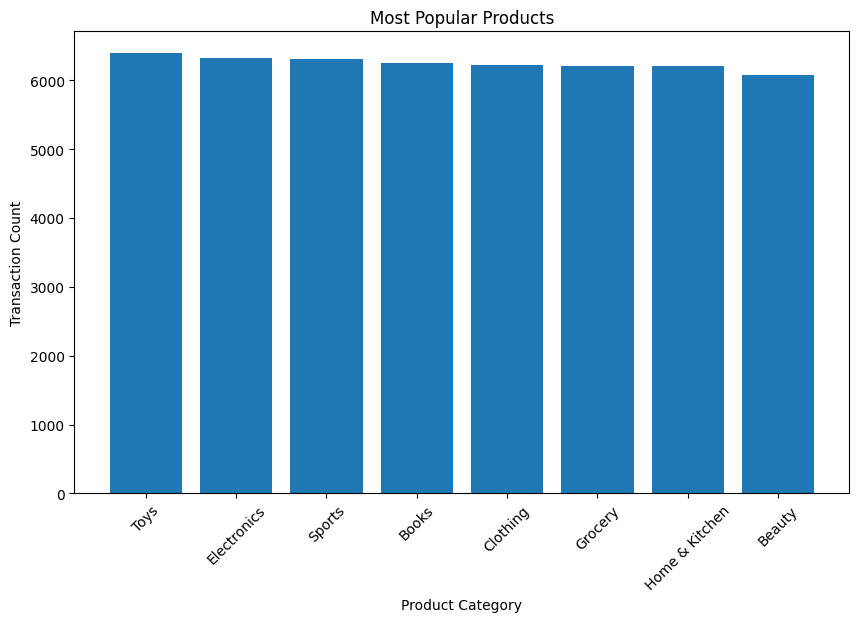

In [11]:
popular_products = ecommerce_df.groupBy("Product_Category").count().orderBy("count", ascending=False).toPandas()
plt.figure(figsize=(10, 6))
plt.bar(popular_products["Product_Category"], popular_products["count"])
plt.title("Most Popular Products")
plt.xlabel("Product Category")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

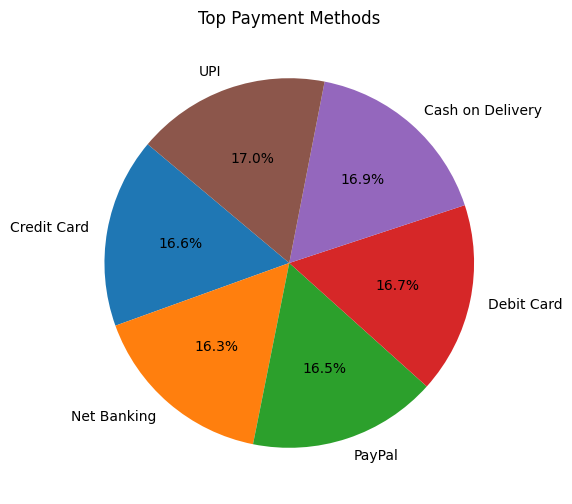

In [12]:
payment_methods = ecommerce_df.groupBy("Payment_Method").count().toPandas()
plt.figure(figsize=(10, 6))
plt.pie(payment_methods["count"], labels=payment_methods["Payment_Method"], autopct='%1.1f%%', startangle=140)
plt.title("Top Payment Methods")
plt.show()

### Identifying Outliers & Anomalies

In [13]:
quantiles = ecommerce_df.approxQuantile("Purchase_Amount", [0.25, 0.75], 0.0)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ecommerce_df.filter((col("Purchase_Amount") < lower_bound) | (col("Purchase_Amount") > upper_bound))
outliers.show()

+--------------+---------+---+-------+----------------+---------------+--------------+----------------+
|Transaction_ID|User_Name|Age|Country|Product_Category|Purchase_Amount|Payment_Method|Transaction_Date|
+--------------+---------+---+-------+----------------+---------------+--------------+----------------+
+--------------+---------+---+-------+----------------+---------------+--------------+----------------+



In [14]:
ecommerce_df.select("Country").distinct().show()

+---------+
|  Country|
+---------+
|  Germany|
|   France|
|    India|
|      USA|
|   Mexico|
|       UK|
|   Canada|
|   Brazil|
|    Japan|
|Australia|
+---------+



In [15]:
ecommerce_df.select("Payment_Method").distinct().show()

+----------------+
|  Payment_Method|
+----------------+
|     Credit Card|
|     Net Banking|
|          PayPal|
|      Debit Card|
|Cash on Delivery|
|             UPI|
+----------------+

